# Portfolio withdrawal analysis

## Question to answer

In [74]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from math import floor
from scipy.stats import norm
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [132]:
#Read file containing S&P500 historical data
file = r'data/SPX.csv'
df = pd.read_csv(file, index_col=None, header=0)

#Date column is String, convert to Python Datetime
df['Date'] = pd.to_datetime(df['Date'])

#Set start date, number of years, withdrawal rate, etc.
start_date = datetime(1927, 12, 30)
end_date = datetime(1969, 9, 28)
withdrawal_rate = 0.05
number_of_years_to_withdraw = 50
portfolio_start_value = 500000

In [122]:
def forward_fill_portfolio_value(df, withdrawal_rate, portfolio_start_value):
    df = df.set_index(np.arange(0, len(df)))
    for i in range(1, len(df)):
        df.loc[i, 'portfolio_value'] = (df.loc[i-1, 'portfolio_value'] * df.loc[i, 'change_since_previous_year'])
        df.loc[i, 'portfolio_value'] = df.loc[i, 'portfolio_value'] - (portfolio_start_value * withdrawal_rate)
    df = df.set_index(pd.DatetimeIndex(df['Date'])).resample(f"365D").agg('first')
    return df

In [123]:
def withdraw_for_n_years(df, start_date, end_date, withdrawal_rate, portfolio_start_value=500000):
    
    df = df[df['Date'] < end_date]
    df = df[df['Date'] >= start_date]
    df['old_index'] = df.index
    df = df.set_index(pd.DatetimeIndex(df['Date'])).resample(f"365D").agg('first')
    
    while(start_date not in df.index):
        start_date = start_date + timedelta(days=1)
    
    #df['open_one_year_later'] = df['Open'].shift(-1)
    df['change_since_previous_year'] = (df['Open']/df['Open'].shift(1)).fillna(1)
    df.loc[start_date, 'portfolio_value'] = portfolio_start_value
    df = forward_fill_portfolio_value(df, withdrawal_rate, portfolio_start_value)
    #display(df)
    df = df[df['portfolio_value'] >= (portfolio_start_value * withdrawal_rate)]
    #years_survived = relativedelta(df['Date'].iloc[-1], df['Date'].iloc[0]).years
    
    if(len(df) == 0):
        return {"start_date": start_date, "end_date": None, "years_survival": 0}
    
    return {"start_date": df.iloc[0]['Date'], "end_date": df.iloc[-1]['Date'], "years_survival": len(df) - 1}
    #df['added_capital'] = dca_monthly_investment_amount / dca_investment_frequency_per_month
    #df['value_period_end'] = df['added_capital'] * (period_last_open / df['Open'])
    #return {"start_date": df.iloc[0]['Date'], "end_date": df.iloc[-1]['Date'], "investment_frequency": floor(30 / dca_investment_frequency_per_month), "value": df['value_period_end'].sum()}

In [133]:
result = []

#Set current date to our simulation start date
current_date = start_date

while current_date < end_date:
    result.append(withdraw_for_n_years(df, current_date, current_date + timedelta(days=365*50), withdrawal_rate, portfolio_start_value))
    
    current_date = current_date + timedelta(days=30)
    
#Convert results to df
results_df = pd.DataFrame(result)

In [134]:
results_df.agg({'years_survival' : ['mean', 'min', 'max', 'median']})

,years_survival
mean,43.068762
min,5.000000
max,49.000000
median,49.000000


In [1]:
display(results_df[results_df['years_survival'] == 5])

NameError: name 'results_df' is not defined

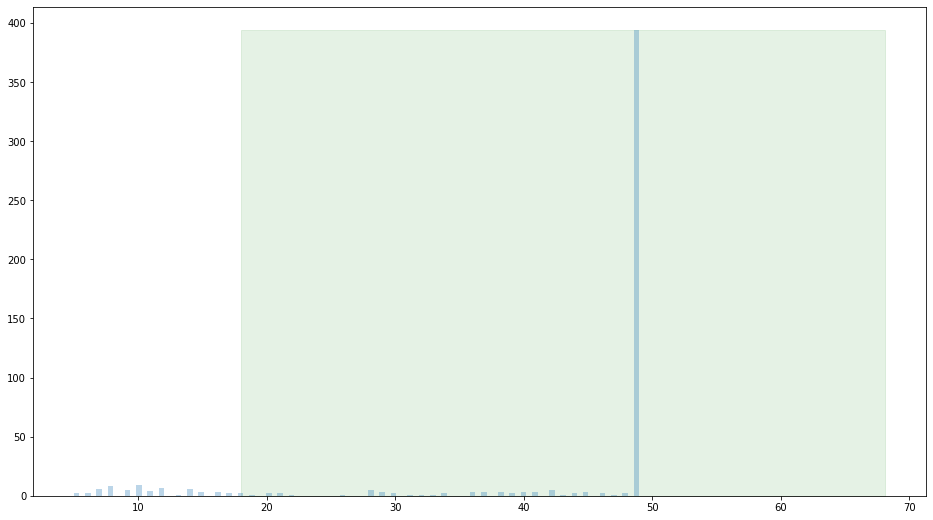

In [135]:
test_df = results_df
arr = test_df['years_survival']
plt.figure(figsize=(16,9))
ci = norm(*norm.fit(arr)).interval(0.95)  # fit a normal distribution and get 95% c.i.
height, bins, patches = plt.hist(arr, alpha=0.3, bins=100)
plt.fill_betweenx([0, height.max()], ci[0], ci[1], color='g', alpha=0.1)